In [47]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [48]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

MapDataset
----------

  Name                            : z_Sft7N1 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
  

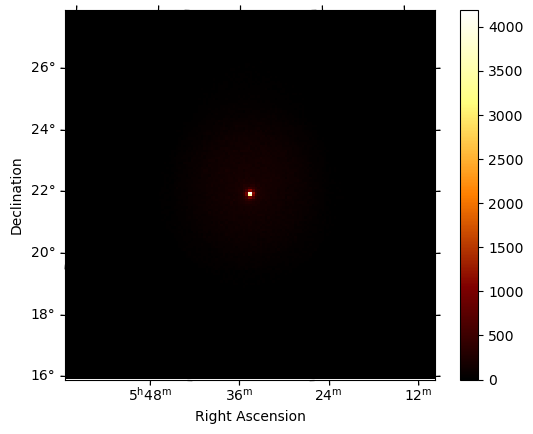

In [49]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models([source_model])

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]

print(dataset_load)

## Standard Case

In [50]:
factor = +0.0

sigma = 0.1

## Drawing the parameters

In [51]:
sys_0 = sys_dataset(dataset_asimov, factor, False)
dataset_0 = sys_0.create_dataset()


In [52]:
fit_0 = Fit(store_trace=False)
result_0 = fit_0.run([dataset_0])

In [53]:
amplitude_scan= dataset_0.models.parameters['amplitude'].scan_values
index_scan= dataset_0.models.parameters['index'].scan_values
N = len(amplitude_scan)
amplitude_scan

array([8.20352444e-13, 8.50698479e-13, 8.82167057e-13, 9.14799704e-13,
       9.48639480e-13, 9.83731038e-13, 1.02012069e-12, 1.05785644e-12,
       1.09698809e-12, 1.13756728e-12, 1.17964756e-12])

In [54]:
%%time
Ls = np.zeros((N, N))
Ls_reopt = np.zeros((N, N))

best_fit_models = []
data = []

dataset_0.models.parameters['amplitude'].frozen = True
dataset_0.models.parameters['index'].frozen = True

for i, a in enumerate(amplitude_scan):
    for j, t in enumerate(index_scan):
        print(i)
        dataset_0.models.parameters['amplitude'].value = a
        dataset_0.models.parameters['index'].value = t
        try:
            L = dataset_0.stat_sum()
            result_0 = fit_0.optimize([dataset_0])      
            L_reopt = dataset_0.stat_sum()
            best_fit_models.append(dataset_0.models[0].copy())
        except:
            print(dataset_0.models.parameters.to_table())
            L = np.nan
            L_reopt = np.nan
            best_fit_models.append(np.nan)
        Ls[i][j] = L
        Ls_reopt[i][j] = L_reopt
        data.append(np.array([a, t, L]))
        
data = np.array(data)

0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
CPU times: user 2min 47s, sys: 177 ms, total: 2min 47s
Wall time: 2min 47s


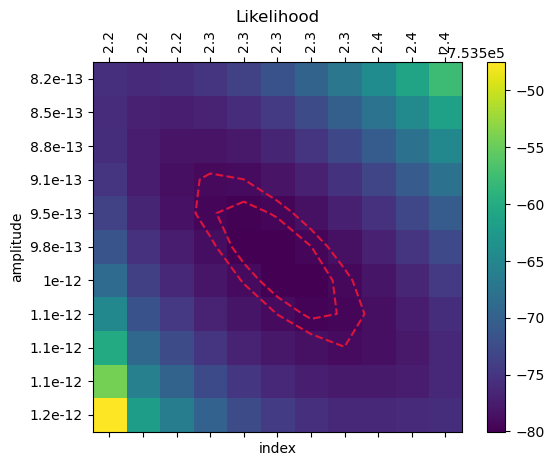

In [55]:
fig, ax = plt.subplots()
cax = ax.matshow(Ls)  # interpolation='nearest')
fig.colorbar(cax);

values_plot_amplitude = amplitude_scan
values_plot_index = index_scan


plt.ylabel("amplitude")
plt.yticks(np.linspace(0, N-1, 11), [ f'{i:.2}' for i in values_plot_amplitude]) 

plt.xlabel("index",)
plt.xticks(np.linspace(0, N-1, 11), [ f'{i:.2}' for i in values_plot_index], rotation=90) 
plt.title(f"Likelihood")

min_ = Ls.min()

CS = plt.contour(np.linspace(0, N-1, N), np.linspace(0, N-1, N),
             Ls, colors=('crimson',),
             levels = [ min_+0.5,min_+1])

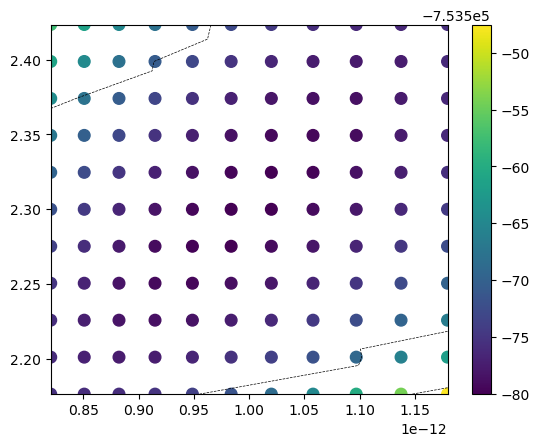

In [56]:
fig, ax = plt.subplots()
im = ax.scatter(data[:,0], data[:,1], c=data[:,2], s= 70
               )#norm = LogNorm())
fig.colorbar(im, ax=ax)
plt.tricontour(data[:,0], data[:,1], data[:,2], levels=1,
               linewidths=0.5, colors='k')

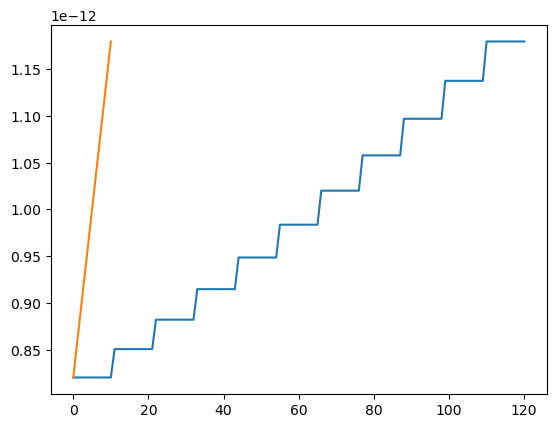

In [57]:
plt.plot(x)
plt.plot(x_new)

In [58]:
x_new

array([8.20352444e-13, 8.56281956e-13, 8.92211467e-13, 9.28140978e-13,
       9.64070489e-13, 1.00000000e-12, 1.03592951e-12, 1.07185902e-12,
       1.10778853e-12, 1.14371804e-12, 1.17964756e-12])

In [59]:
x ==x_new

/tmp/ipykernel_331134/3963931592.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  x ==x_new


False

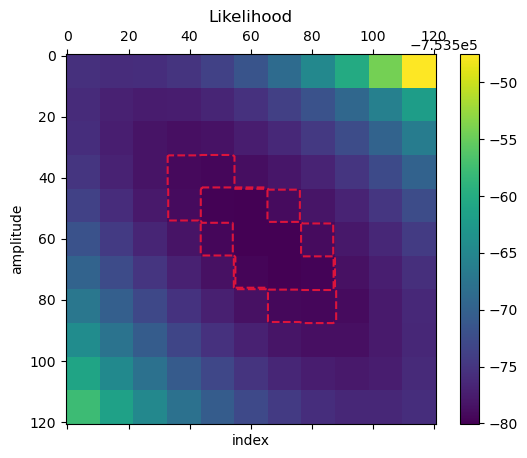

In [60]:
from scipy.interpolate import interp2d

x = data[:,0]
y = data[:,1]
N_new = 11
N_new_i = 11
x_new =  np.linspace(x[0], x[-1],N_new)
y_new =  np.linspace(y[0], y[-1],N_new_i)


f = interp2d(x = x, y= y, z = data[:,2], kind='cubic',fill_value = None, bounds_error = False )
Ls_new = f(x_new, y_new)
Ls_new = f(x, y)

max_ = Ls_new.max()
#Ls_new = Ls_new  - max_

min_ = Ls_new.min()

fig, ax = plt.subplots()
cax = ax.matshow(Ls_new)  # interpolation='nearest')
fig.colorbar(cax);

plt.ylabel("amplitude")
#plt.yticks(np.linspace(0, N_new-1, len(values_plot_amplitude)),
#           [ f'{i:.2}' for i in values_plot_amplitude]) 

plt.xlabel("index",)
#plt.xticks(np.linspace(0, N_new_i-1, len(values_plot_index)),
#           [ f'{i:.2}' for i in values_plot_index], rotation=90) 
plt.title(f"Likelihood")

CS = plt.contour(Ls_new, colors=('crimson',), levels = [ min_+0.5,min_+1])

In [61]:
def compute_fraction(threshold):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    masked = Ls_new* (Ls_new < offset)
    print("sum inside", np.sum(masked), " of ", tot_int)
    print("pix inside", np.count_nonzero(masked), " of ", N_new_i * N_new)
    
    fraction=  np.sum(masked)/ tot_int 
    print(fraction)
    fig, ax = plt.subplots()
    cax = ax.matshow(masked, )  # interpolation='nearest')
    fig.colorbar(cax);
    CS = plt.contour(Ls_new, colors=('crimson',), levels = [ min_+0.5,min_+1])    
    return fraction

sum inside -2644308819.46411  of  -11033079187.321838
pix inside 3509  of  121
0.23967097258784267


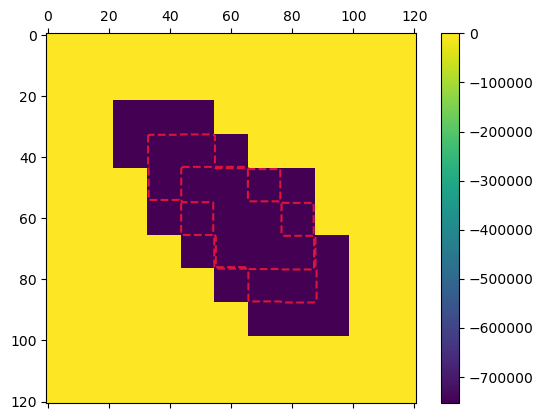

In [62]:
fraction = compute_fraction(2)


In [63]:
def masking(fraction):
    from operator import itemgetter

    a = Ls_new
    b = [((i, j), v) for i, t in enumerate(a) for j, v in enumerate(t)]
    b.sort(key=itemgetter(-1), reverse=True)
    coords, vals = zip(*b)
    total = sum(vals)
    print(total)
    lim = int(fraction * total)
    selected = []
    s = 0
    for t, v in b:
        if s + v >= lim:
            s += v
            selected.append(t)
        else:
            break
    Ls_masked = a.copy()

    for sec in selected:
        Ls_masked[sec] = np.nan
    return Ls_masked


-11033079187.321756


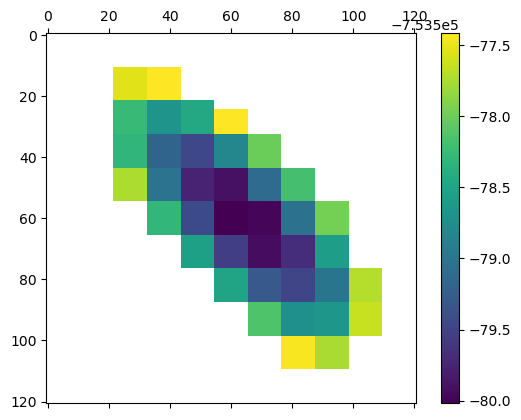

In [64]:
mask = masking(0.68)
fig, ax = plt.subplots()
cax = ax.matshow(mask )  # interpolation='nearest')
fig.colorbar(cax);

In [65]:
np.nanmax(mask) - np.nanmin(mask)

2.5992815650533885

In [72]:
d = 785 
r2 = 5.5
r1 = 120 

A = np.pi * r1 **2 #- np.pi * r2**2 
S = A / d / d

In [76]:
omega = 3.42e-2
A = omega * d * d
np.sqrt(A / np.pi )

81.90450188350663